In [12]:
################################################################
#              By Rui Paiva and Shoaib                         #  
#                  2022/2023                                   #
#                                                              #
#               Tomar, Portugal                                #
################################################################

Neste exercício pretende-se reunir os dados meteorológicos de um conjunto de cidades portuguesas bem como a sua distância para uma cidade de referência. Pretende-se com esta base de dados reunir informação que permita no futuro aplicar um algoritmo de machine learning que estude o efeito (se algum) que a proximidade de uma cidade, ao mar, tem no clima local. Para esse efeito, pretende-se reunir um conjunto de 10 cidades com diferentes distâncias relativamente a uma cidade costeira de referência. Na escolha das cidades deve-se optar por deixar de fora, cidades montanhosas por forma a evitar a introdução de outros fatores que poderão afetar o clima (nomeadamente a altitude).

In [1]:
# install the folium library
!pip install folium
# install the geopy library
!pip install geopy

In [5]:
# import libraries
import time
import requests
import pprint
import json
import os.path
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
import folium
import datetime
import matplotlib.pyplot as plt

## Obtensão das coordenadas das cidades escolhidas

Foram escolhidas cidades, com uma altitude semelhante, a fim de tornar a análise mais coerente.

In [6]:
# list of cities, first will be used as reference city
cities = ['caldas da rainha', 'viseu', 'coimbra', 'leiria', 'tomar', 'santarém','aveiro','soure','odemira', 'lagoa', 'faro']

geolocator = Nominatim(user_agent='ipt_big_data_rui_shoaib') # create a Nominatim geolocator specifying a user agent
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) # pass it through a rate limiter to not exceed limits imposed by Nominatim (1 request/s)

cities_df = pd.DataFrame(columns=['city', 'latitude', 'longitude']) # create a dataframe to hold the data

# iterate through each city
for city in cities:
    raw = geocode(city) # geocode with a delay form the ratelimiter
    if raw:
        cities_df = pd.concat([cities_df, pd.DataFrame([{
            'city': city,
            'latitude': raw.latitude,
            'longitude': raw.longitude,
        }])], ignore_index=True) # append to dataframe
    else:
        print(f'Error: failed to geocode {city}')

cities_df # display dataframe

,city,latitude,longitude
0,caldas da rainha,39.407186,-9.134600
1,viseu,40.657471,-7.913866
2,coimbra,40.211193,-8.429463
3,leiria,39.743790,-8.807112
4,tomar,39.603660,-8.415049
5,santarém,39.236364,-8.686708
6,aveiro,40.640496,-8.653784
7,soure,40.059503,-8.626390
8,odemira,37.597600,-8.642200
9,lagoa,37.132581,-8.455051


## Recorra a packages de geocoding (e.g., “Geopy” (https://geopy.readthedocs.io/en/stable/) para obter de forma programática a distância entre as cidades selecionadas e a cidade de referência.

In [7]:
ref_city = cities_df.iloc[0] # first city as ref

for i, row in cities_df.iterrows():
    ref_coor = (ref_city['latitude'], ref_city['longitude']) # ref city coordinates
    cur_coor = (row['latitude'], row['longitude']) # current city coordinates
    dist = distance.distance(ref_coor, cur_coor).km # calculates distance between ref city & current city in km
    cities_df.at[i, 'ref_city'] = ref_city['city'] # it's a good idea to keep track of ref city individually by adding a col, in case we use multiple ref cities in the future
    cities_df.at[i, 'dist_to_ref_km'] = dist # add a col with the distance

ref_city = cities_df.iloc[0] # update ref city

cities_df.to_json('cities_df.json') # export to json

cities_df # display dataframe

,city,latitude,longitude,ref_city,dist_to_ref_km
0,caldas da rainha,39.407186,-9.134600,caldas da rainha,0.000000
1,viseu,40.657471,-7.913866,caldas da rainha,173.572683
2,coimbra,40.211193,-8.429463,caldas da rainha,107.772091
3,leiria,39.743790,-8.807112,caldas da rainha,46.780356
4,tomar,39.603660,-8.415049,caldas da rainha,65.617884
5,santarém,39.236364,-8.686708,caldas da rainha,43.027837
6,aveiro,40.640496,-8.653784,caldas da rainha,142.958755
7,soure,40.059503,-8.626390,caldas da rainha,84.519590
8,odemira,37.597600,-8.642200,caldas da rainha,205.414604
9,lagoa,37.132581,-8.455051,caldas da rainha,259.390740


## Recorra a uma biblioteca Python que permita plotar num mapa google as localidades consideradas.

In [5]:
map = folium.Map(location=[39.3, -8], zoom_start=7) # create a map object

def getMarkerPopup(row, reference=False):
    return """
<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h4>"""+row['city'].title()+"""</h4>
""" + ("<h5>(Reference City)</h5>" if reference else "")+ """

<table>
  <tr>
    <th>Latitude</th>
    <th>Longitude</th>
    <th>Reference City</th>
    <th>Distance to Reference City</th>
  </tr>
  <tr>
    <td>""" + str(row['latitude']) + """</td>
    <td>""" + str(row['longitude']) + """</td>
    <td>""" + row['ref_city'].title() + """</td>
    <td>{:.2f}""".format(row['dist_to_ref_km']) + """ KM</td>
  </tr>
</table>

</body>
</html>
    """

folium.Marker(
    location=(ref_city['latitude'], ref_city['longitude']),
    popup=getMarkerPopup(ref_city, True),
    icon=folium.Icon(color='green')
).add_to(map) # add reference city marker and make it stand out

# iterate over the dataframe, [1:] skips first row bcz it's the ref city
for i, row in cities_df[1:].iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=getMarkerPopup(row)).add_to(map) # add a marker for each city to the map

map # display the map

## Com recurso à API “Current Weather” (https://openweathermap.org/current) obtenha os seguintes dados meteorológicos a cada hora durante o espaço de 5 dias consecutivos:
• Temperature

• Humidity

• Pressure

• Description

• Wind speed

• Wind degree

• Timestamp (dt)

In [6]:
openweathermap_api_key = '2c7a57835bdb1afab7ea8699e8b319d4' # openweathermap api keys take ~2 hours to be activated, until then a 401 will be received

filename = 'hourly_weather.json'

# run every hour indefintely until interrupted forcefully
while True == False: # remove == False to run
    snapshots = []

    # check if file exists, if yes load it as json. This could fail if file conent is not a json array
    if os.path.isfile(filename):
        # read JSON file
        with open(filename) as fp:
            snapshots = json.load(fp)

    for i, row in cities_df.iterrows():
        # https://openweathermap.org/current
        res = requests.get(f'https://api.openweathermap.org/data/2.5/weather?lat={row["latitude"]}&lon={row["longitude"]}&units=metric&appid={openweathermap_api_key}')
        if res.status_code == 200:
            weather = res.json()
            # we are interested in Temperature • Humidity • Pressure • Description • Wind speed • Wind degree • Timestamp (dt)
            snapshot = {
                'city': row['city'],
                'timestamp': weather['dt'],
                'temp_celcius': weather['main']['temp'],
                'humidity': weather['main']['humidity'],
                'pressure_millibar': weather['main']['pressure'],
                'wind_speed_m_per_s': weather['wind']['speed'],
                'wind_dir_deg': weather['wind']['deg'],
                'description': weather['weather'][0]['description'], # first description
            }
            snapshots.append(snapshot)
        else:
            print(f'Error: failed to get weather data for {row["city"]}')

    with open(filename, 'w') as json_file:
        json.dump(snapshots, json_file, indent=4,separators=(',',': '))

    print(f'Appended weather snapshots to {filename}. Next job in 1 hour')

    time.sleep(3600)

In [8]:
# File name
file_name = "hourly_weather.json"

with open(file_name, "r") as readfile: #open file on mode read
    data = json.load(readfile)

#Print with pretty print
pprint.pprint(data)

[{'city': 'caldas da rainha',
  'description': 'overcast clouds',
  'humidity': 85,
  'pressure_millibar': 1023,
  'temp_celcius': 15.68,
  'timestamp': 1672244170,
  'wind_dir_deg': 189,
  'wind_speed_m_per_s': 2.68},
 {'city': 'viseu',
  'description': 'overcast clouds',
  'humidity': 92,
  'pressure_millibar': 1023,
  'temp_celcius': 13.6,
  'timestamp': 1672243804,
  'wind_dir_deg': 229,
  'wind_speed_m_per_s': 3.44},
 {'city': 'coimbra',
  'description': 'overcast clouds',
  'humidity': 86,
  'pressure_millibar': 1024,
  'temp_celcius': 16.97,
  'timestamp': 1672243804,
  'wind_dir_deg': 223,
  'wind_speed_m_per_s': 3.11},
 {'city': 'leiria',
  'description': 'overcast clouds',
  'humidity': 79,
  'pressure_millibar': 1024,
  'temp_celcius': 16.03,
  'timestamp': 1672243820,
  'wind_dir_deg': 178,
  'wind_speed_m_per_s': 0.45},
 {'city': 'tomar',
  'description': 'overcast clouds',
  'humidity': 92,
  'pressure_millibar': 1024,
  'temp_celcius': 12.88,
  'timestamp': 1672243756,
 

## Liste os dados num dataframe.

In [9]:
df = pd.DataFrame.from_dict(data, orient='columns')
df #list data

,city,timestamp,temp_celcius,humidity,pressure_millibar,wind_speed_m_per_s,wind_dir_deg,description
0,caldas da rainha,1672244170,15.68,85,1023,2.68,189,overcast clouds
1,viseu,1672243804,13.60,92,1023,3.44,229,overcast clouds
2,coimbra,1672243804,16.97,86,1024,3.11,223,overcast clouds
3,leiria,1672243820,16.03,79,1024,0.45,178,overcast clouds
4,tomar,1672243756,12.88,92,1024,2.28,208,overcast clouds
...,...,...,...,...,...,...,...,...
1821,aveiro,1672733092,7.06,80,1032,2.45,109,scattered clouds
1822,soure,1672733092,5.63,88,1032,1.51,83,scattered clouds
1823,odemira,1672733093,7.83,89,1031,2.02,37,clear sky
1824,lagoa,1672733093,8.15,78,1030,3.85,6,clear sky


In [10]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s') #convert timestamp to date time
df['Date'], df['Time'] = df['datetime'].dt.normalize(), df['datetime'].dt.time

In [11]:
df.head()

,city,timestamp,temp_celcius,humidity,pressure_millibar,wind_speed_m_per_s,wind_dir_deg,description,datetime,Date,Time
0,caldas da rainha,1672244170,15.68,85,1023,2.68,189,overcast clouds,2022-12-28 16:16:10,2022-12-28,16:16:10
1,viseu,1672243804,13.60,92,1023,3.44,229,overcast clouds,2022-12-28 16:10:04,2022-12-28,16:10:04
2,coimbra,1672243804,16.97,86,1024,3.11,223,overcast clouds,2022-12-28 16:10:04,2022-12-28,16:10:04
3,leiria,1672243820,16.03,79,1024,0.45,178,overcast clouds,2022-12-28 16:10:20,2022-12-28,16:10:20
4,tomar,1672243756,12.88,92,1024,2.28,208,overcast clouds,2022-12-28 16:09:16,2022-12-28,16:09:16


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   city                1826 non-null   object        
 1   timestamp           1826 non-null   int64         
 2   temp_celcius        1826 non-null   float64       
 3   humidity            1826 non-null   int64         
 4   pressure_millibar   1826 non-null   int64         
 5   wind_speed_m_per_s  1826 non-null   float64       
 6   wind_dir_deg        1826 non-null   int64         
 7   description         1826 non-null   object        
 8   datetime            1826 non-null   datetime64[ns]
 9   Date                1826 non-null   datetime64[ns]
 10  Time                1826 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 157.0+ KB


## Proceda a uma análise gráfica dos resultados referindo-se/justificando os resultados obtidos.

### Verifique a evolução da temperatura num dado dia numa cidade à sua escolha.

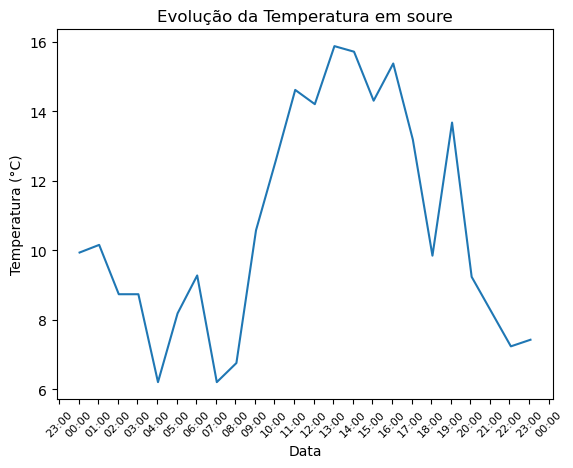

Valor minimo da temp: 6.2
Valor máximo: 15.87


In [14]:
import matplotlib.dates as mdates

city = 'soure'
date = '2023-01-02'

#filter by city and date
df_city = df[(df['city'] == city) & (df['Date'] == date)]

plt.plot(df_city['datetime'], df_city['temp_celcius'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura em {city}')
plt.xticks(rotation=45, fontsize=8)
plt.show()

# calculate the min and max
min_value = df_city['temp_celcius'].min()
max_value = df_city['temp_celcius'].max()
print(f"Valor minimo da temp: " + str(min_value))
print(f"Valor máximo: " + str(max_value))

Na cidade escolhida, neste caso Soure, durante o dia 02/01/2023, registaram-se grandes variações da temperatura, com o minimo a registar os 6.2 graus celsius por volta das 4h, e 15,87 graus celsius de máxima, por volta das 14h.

### Verifique a evolução da temperatura no conjunto dos 5 dias coletados numa cidade à sua escolha.

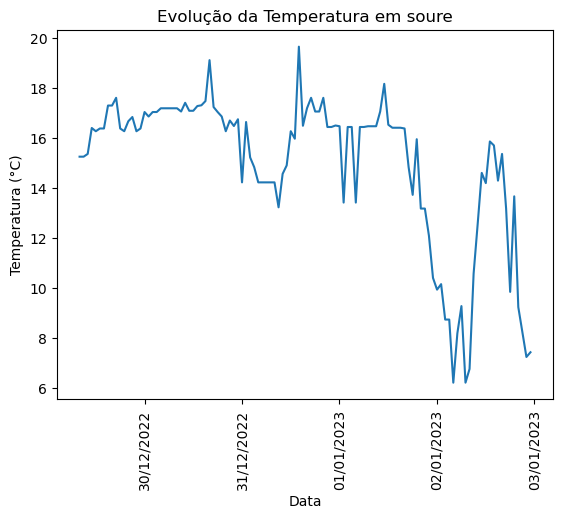

In [17]:
#city = 'soure'
start_date = '2022-12-29'
end_date = '2023-01-02'

#filter by city and date
df_filtred = df[( (df['city'] == city)) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]

# plot date/temp
plt.plot(df_filtred['datetime'], df_filtred['temp_celcius'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura em {city}')
plt.xticks(rotation=90)
plt.show()

Durante os cinco dias em análise, a temperatura teve tendência descendente, com variações diárias durante os diversos periodos do dia.<br> O dia mais frio foi o dia 03/01/2023, e o dia mais quente 01/01/2023.

### Verifique a evolução da temperatura num dado dia em 6 cidades à sua escolha. Uma vez que o objetivo é analisar como e se a proximidade ao mar influencia o tempo, deverá começar por escolher as 3 cidades mais próximas ao mar (a verde no exemplo) e as 3 mais afastadas (a vermelho no exemplo).

Foram adicionadas manualmente as distâncias ao mar.

In [18]:
distance_from_sea = {
    'caldas da rainha': 8.81,
    'viseu': 68.49,
    'coimbra': 38.97,
    'leiria': 17.38,
    'tomar': 56.38,
    'santarém': 49.48,
    'aveiro': 8,
    'soure': 21.29,
    'odemira': 14.3,
    'lagoa': 0,
    'faro': 5
}

for i, city in enumerate(cities_df.city):
    cities_df.at[i, 'dist_from_sea_km'] = distance_from_sea[city]

cities_df

,city,latitude,longitude,ref_city,dist_to_ref_km,dist_from_sea_km
0,caldas da rainha,39.407186,-9.134600,caldas da rainha,0.000000,8.81
1,viseu,40.657471,-7.913866,caldas da rainha,173.572683,68.49
2,coimbra,40.211193,-8.429463,caldas da rainha,107.772091,38.97
3,leiria,39.743790,-8.807112,caldas da rainha,46.780356,17.38
4,tomar,39.603660,-8.415049,caldas da rainha,65.617884,56.38
5,santarém,39.236364,-8.686708,caldas da rainha,43.027837,49.48
6,aveiro,40.640496,-8.653784,caldas da rainha,142.958755,8.00
7,soure,40.059503,-8.626390,caldas da rainha,84.519590,21.29
8,odemira,37.597600,-8.642200,caldas da rainha,205.414604,14.30
9,lagoa,37.132581,-8.455051,caldas da rainha,259.390740,0.00


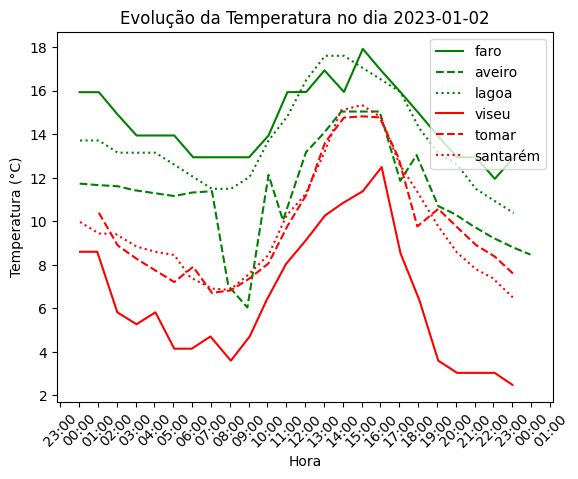

In [147]:
#Near sea
city = 'faro'
city2 = 'aveiro'
city3 = 'lagoa'
#
city4 = 'viseu'
city5 = 'tomar'
city6 = 'santarém'

#data
start_date = '2023-01-02'
end_date = '2023-01-02'

cities = [city, city2, city3, city4, city5, city6]
df_filtered_list = []
colors = ['g', 'g--', 'g:', 'r', 'r--', 'r:']

for i, city in enumerate(cities):
    df_filtered = df[(df['city'] == city) & (df['Date'] >= start_date) & (df['Date'] <= end_date)]
    plt.plot(df_filtered['datetime'], df_filtered['temp_celcius'], colors[i], label=city)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.legend()
plt.xlabel('Hora')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura no dia {start_date}')
plt.xticks(rotation=45)
plt.show()

Recorrendo ao gráfico, podemos constatar que a proximidade ao mar, influência a temperatura.
As três cidades escolhidas, que se situam perto do mar (a verde), tiveram todas temperatura superior às outras três (a vermelho), que se encontram mais afastadas. As temperatus mais altas, situam-se por volta das 14h, e a mínima por volta da meia noite.

### Aprofunde a sua análise ao correlacionar num scatter plot (gráfico de dispersão) a relação entre a distância que separa as 10 cidades do mar e a respetiva temperatura máxima.

In [25]:
max_min_temp_df = cities_df.copy() #new dataframe

start_date = '2023-01-02'
end_date = '2023-01-02'

for i, city in enumerate(max_min_temp_df.city):
    city_df = df[(df['city'] == city) & (df['Date'] >= start_date) & (df['Date'] <= end_date)]
    city_max = city_df['temp_celcius'].max()
    city_min = city_df['temp_celcius'].min()
    max_min_temp_df.at[i, 'max_temp'] = city_max
    max_min_temp_df.at[i, 'min_temp'] = city_min

max_min_temp_df = max_min_temp_df.sort_values(by='dist_to_ref_km', ascending=True) #ordering ascending by dist_to_ref_km
max_min_temp_df #view dataframe

,city,latitude,longitude,ref_city,dist_to_ref_km,dist_from_sea_km,max_temp,min_temp
0,caldas da rainha,39.407186,-9.134600,caldas da rainha,0.000000,8.81,14.67,8.15
5,santarém,39.236364,-8.686708,caldas da rainha,43.027837,49.48,15.34,6.47
3,leiria,39.743790,-8.807112,caldas da rainha,46.780356,17.38,15.37,5.33
4,tomar,39.603660,-8.415049,caldas da rainha,65.617884,56.38,14.82,6.71
7,soure,40.059503,-8.626390,caldas da rainha,84.519590,21.29,15.87,6.20
2,coimbra,40.211193,-8.429463,caldas da rainha,107.772091,38.97,15.72,5.77
6,aveiro,40.640496,-8.653784,caldas da rainha,142.958755,8.00,15.04,6.04
1,viseu,40.657471,-7.913866,caldas da rainha,173.572683,68.49,12.49,2.49
8,odemira,37.597600,-8.642200,caldas da rainha,205.414604,14.30,15.05,10.05
9,lagoa,37.132581,-8.455051,caldas da rainha,259.390740,0.00,17.60,10.38


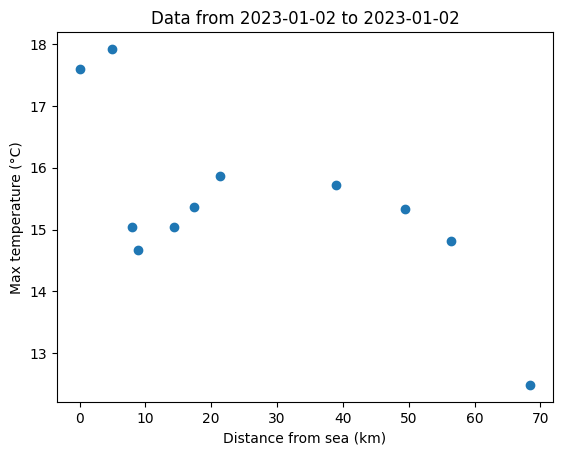

In [149]:
# Crie o gráfico de dispersão
plt.scatter(max_min_temp_df.dist_from_sea_km, max_min_temp_df.max_temp)

# Adicione títulos aos eixos
plt.title(f'Data from {start_date} to {end_date}')
plt.xlabel(f'Distance from sea (km)')
plt.ylabel(f'Max temperature (°C)')

# Mostre o gráfico
plt.show()

Este exemplo usa a biblioteca matplotlib para criar o gráfico. 
O primeiro passo é criar uma lista de tuplas que representam as 10 cidades, com as distâncias e temperaturas máximas.
Em seguida, extraimos as distâncias e temperaturas máximas para seus respectivos arrays. O método scatter é usado para 
criar o gráfico de dispersão.
A distância ao mar influência a temperatura, no sentido em que a temperatura máxima diminui com o afastamento ao mar.

### Aprofunde a sua análise ao correlacionar num scatter plot (gráfico de dispersão) a relação entre a distância que separa as 10 cidades do mar e a respetiva temperatura mínima.

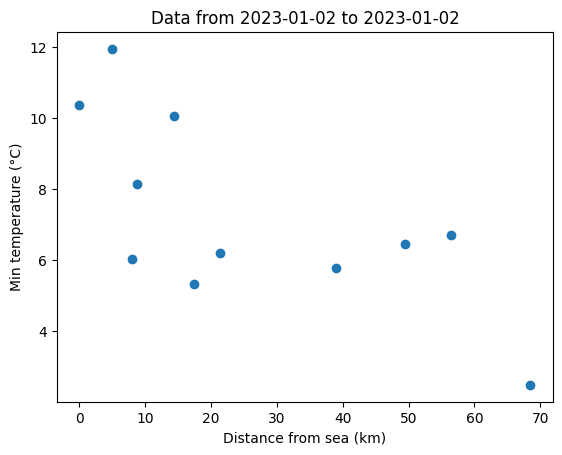

In [150]:
# Crie o gráfico de dispersão
plt.scatter(max_min_temp_df.dist_from_sea_km, max_min_temp_df.min_temp)

# Adicione títulos aos eixos
plt.title(f'Data from {start_date} to {end_date}')
plt.xlabel(f'Distance from sea (km)')
plt.ylabel(f'Min temperature (°C)')

# Mostre o gráfico
plt.show()

Ao contrário da análise efetuada à temperatura máxima, a temperatura minima não tem um comportamento regular, não podendo dizer que a temperatura minima é influênciada pela distância ao mar.

### Verifique a evolução da humidade num dado dia em 6 cidades à sua escolha. Uma vez que o objetivo é analisar como e se a proximidade ao mar influencia o tempo, deverá começar por escolher as 3 cidades mais próximas ao mar (a verde no exemplo) e as 3 mais afastadas (a vermelho no exemplo).

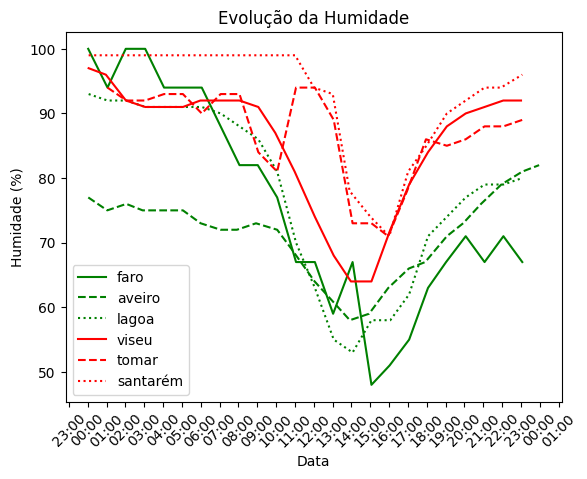

In [151]:
#Próximas o mar (verde)
city = 'faro'
city2 = 'aveiro'
city3 = 'lagoa'
#Afastadas do mar (vermelho)
city4 = 'viseu'
city5 = 'tomar'
city6 = 'santarém'

#data
start_date = '2023-01-02'
end_date = '2023-01-02'

cities = [city, city2, city3, city4, city5, city6]
df_filtered_list = []
colors = ['g', 'g--', 'g:', 'r', 'r--', 'r:']

for i, city in enumerate(cities):
    df_filtered = df[(df['city'] == city) & (df['Date'] >= start_date) & (df['Date'] <= end_date)]
    plt.plot(df_filtered['datetime'], df_filtered['humidity'], colors[i], label=city)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.legend()
plt.xlabel('Data')
plt.ylabel('Humidade (%)')
plt.title(f'Evolução da Humidade')
plt.xticks(rotation=45)
plt.show()

A humidade é mais elevada no periodo noturno, atingindo os seus valores minimos por volta das 14h.
As cidades mais afastadas do mar, têm a humidade mais elevada que as que se enontram mais pròximas.
A variação entre todas as cidades da humidade, regista evoluções idênticas.

### Aprofunde a sua análise ao correlacionar num scatter plot (gráfico de dispersão) a relação entre a distância que separa as 10 cidades do mar e as respetivas humidades máximas e mínimas (obtidas entre os vários dias de coleta considerados). Considere o recurso à funcionalidade de subplot para mostrar ambos os gráficos um ao lado do outro.

In [152]:
max_min_humidity_df = max_min_temp_df.copy()

start_date = '2023-01-02'
end_date = '2023-01-02'

for i, city in enumerate(max_min_humidity_df.city):
    city_df = df[(df['city'] == city) & (df['Date'] >= start_date) & (df['Date'] <= end_date)]
    city_max = city_df['humidity'].max()
    city_min = city_df['humidity'].min()
    max_min_humidity_df.at[i, 'max_humidity'] = city_max
    max_min_humidity_df.at[i, 'min_humidity'] = city_min

max_min_humidity_df

,city,latitude,longitude,ref_city,dist_to_ref_km,dist_from_sea_km,max_temp,min_temp,max_humidity,min_humidity
0,caldas da rainha,39.407186,-9.134600,caldas da rainha,0.000000,8.81,14.67,8.15,95.0,66.0
1,viseu,40.657471,-7.913866,caldas da rainha,173.572683,68.49,12.49,2.49,97.0,64.0
2,coimbra,40.211193,-8.429463,caldas da rainha,107.772091,38.97,15.72,5.77,94.0,61.0
3,leiria,39.743790,-8.807112,caldas da rainha,46.780356,17.38,15.37,5.33,100.0,65.0
4,tomar,39.603660,-8.415049,caldas da rainha,65.617884,56.38,14.82,6.71,94.0,71.0
5,santarém,39.236364,-8.686708,caldas da rainha,43.027837,49.48,15.34,6.47,99.0,71.0
6,aveiro,40.640496,-8.653784,caldas da rainha,142.958755,8.00,15.04,6.04,82.0,58.0
7,soure,40.059503,-8.626390,caldas da rainha,84.519590,21.29,15.87,6.20,89.0,59.0
8,odemira,37.597600,-8.642200,caldas da rainha,205.414604,14.30,15.05,10.05,90.0,62.0
9,lagoa,37.132581,-8.455051,caldas da rainha,259.390740,0.00,17.60,10.38,93.0,53.0


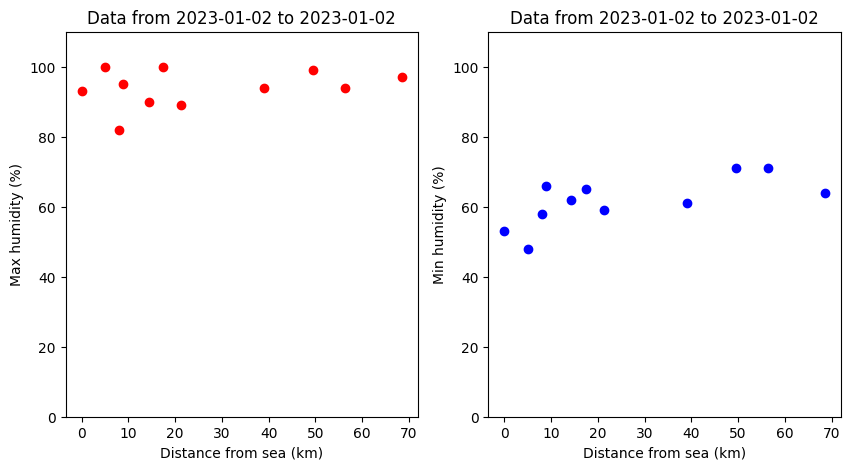

In [159]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.scatter(max_min_humidity_df.dist_from_sea_km, max_min_humidity_df.max_humidity, color='r')
plt.title(f'Data from {start_date} to {end_date}')
plt.xlabel(f'Distance from sea (km)')
plt.ylabel(f'Max humidity (%)')
plt.ylim(0, 110)

plt.subplot(1, 2, 2)
plt.scatter(max_min_humidity_df.dist_from_sea_km, max_min_humidity_df.min_humidity, color='b')
plt.title(f'Data from {start_date} to {end_date}')
plt.xlabel(f'Distance from sea (km)')
plt.ylabel(f'Min humidity (%)')
plt.ylim(0, 110)

plt.show()

Em relação à humidade máxima, a mesma variou entre os 80%-100%, não se verificando influência da distância ao mar sobre a humidade.
A humidade minima, nas cidades perto do mar, cifra-se em torno dos 60%. Mais afastado do mar, sobe ligueiramente.

### Crie um Heatmap da correlação entre as diversas variáveis. Retire conclusões acerca dos dados obtidos.

In [11]:
correlations = df.corr()
correlations

,timestamp,temp_celcius,humidity,pressure_millibar,wind_speed_m_per_s,wind_dir_deg
timestamp,1.000000,-0.443989,-0.213325,0.060497,-0.016091,-0.267888
temp_celcius,-0.443989,1.000000,-0.298232,-0.285695,0.466366,0.203548
humidity,-0.213325,-0.298232,1.000000,-0.255142,-0.190899,-0.062841
pressure_millibar,0.060497,-0.285695,-0.255142,1.000000,-0.234769,-0.111191
wind_speed_m_per_s,-0.016091,0.466366,-0.190899,-0.234769,1.000000,-0.005737
wind_dir_deg,-0.267888,0.203548,-0.062841,-0.111191,-0.005737,1.000000


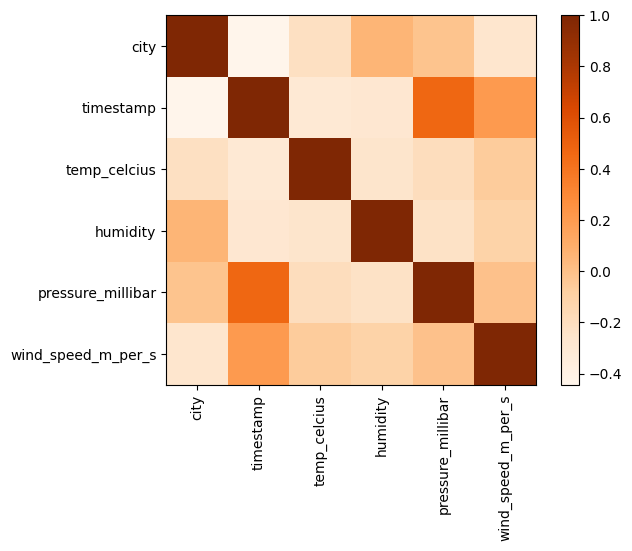

In [161]:
labels = df.columns

plt.xticks(ticks=range(len(labels)), labels=labels,rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)

hm = plt.imshow(correlations, cmap = 'Oranges' , interpolation = 'nearest' )
plt.colorbar(hm)

Podemos observar features com correlação positiva, e outros negativa.
Timestamp e pressure milibar, têm correlação positiva forte, o que significa, que quando um aumenta, o outro também.
Timestamp e wind speed, têm correlação negativa, o que significa que quando o timstamp aumenta, o wind speed diminui.